# Study of the Progressive Headging (PH) Algorithm

### References

[1] Watson, Jean-Paul, and David L. Woodruff. "Progressive hedging innovations for a class of stochastic mixed-integer resource allocation problems." Computational Management Science 8.4 (2011): 355.

[2] Rockafellar, R.T. Solving Stochastic Programming Problems with Risk Measures by Progressive Hedging. Set-Valued Var. Anal 26, 759–768 (2018). https://doi.org/10.1007/s11228-017-0437-4

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import pyomo.environ as pyo

The progressive hedging algorithm proceeds as follows

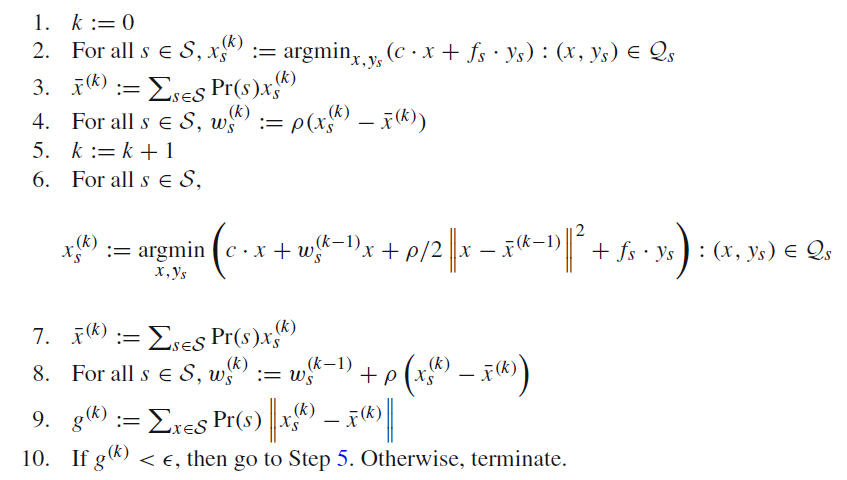

where:

 - $s \in S$ holds the set of possible scenarioes
 - $x_s$ is a variable decision vector $\in R^{n \times 1}$
 - $c$ is a parameter vector of costs $\in R^{n \times 1}$
 - $x_s \in Q_s$ expresses the problem constraints to ensure $x_s$ is a feasible solution to scenario $s$
 - Pr($s$) is the probability of occurance for scenario $s$
 - $x$ is the variable vector of common decisions (with $x_s=x, \forall s \in S$)
 - $y_s$ represents second-stage, scenario-specific decision fectors with associated cost coefficient vectors $f_s$. these are determined given $x$ and a particular $s \in S$
 - $\rho > 0$ is a parameterized penalty factor
 - $\epsilon$ is the termination threshold

Let's consider the farmer problem.
This is the extensive form of the farmer problem example.
  (section 1.1b, pg. 7-8, Birge & Louveax)

A farmer is trying to decide what to plant for the next season.

  - He has wheat (1), corn (2), and sugar beets (3)
  - He can buy ($y$), sell ($w$), and produce ($x$,$x_{yield}$) any of these three products.
  - He must buy / produce a min. amount of wheat / corn for his cattle.
  - Quota on sugar beets alters the price after a certain threshold.
  
Goal: max. the net proficts from purchasing, selling, and planting crops for next season.

However, there is no guarantees on the weather. The actual yield of the crops changes depending on weather -> aka uncertain.
Here, let's consider 3 scenarios: good, fair, or bad weather next year.

In [3]:
class Farmer():
    def __init__(self, weather_types):
        """
        Initialize the Farmer, using a list of weather types.
        In this case, the actual crop yields are considered stochastic.
        All else (acres, planting cost, selling prices, purchase prices, quota levels) are deterministic.

        Args:
            weather_types : list of str
                List of strings, containing which weather scenarios to include.
                Should be composed of "good","fair", and/or "bad"
        Returns:
            None.
            
        """

        # record the scenario (i.e. weather type)
        self.weathers=weather_types

        # determine the yield, based on the scenario
        self._generate_crop_yield_scenarios(weather_types)

        # these attributes not change, regardless of scenario.
        self.total_acres=500
        self.planting_cost={"wheat":150,
                            "corn":230,
                            "beets":260}
        self.planting_crops=["wheat","corn","beets"]
        self.selling_price={"wheat":170,
                            "corn":150,
                            "beets_favorable":36, 
                            "beets_unfavorable":10}
        self.selling_crops=["wheat", "corn", "beets_favorable", "beets_unfavorable"]
        self.min_requirement={"wheat":200,
                              "corn":240}
        self.purchase_price={"wheat":238,
                             "corn":210}
        self.purchasing_crops=["wheat","corn"]
        self.required_crops=self.purchasing_crops
        self.beets_quota=6000

        # add deterministic models, indexed by their weather
        self.deterministic_model={weather:self._build_deterministic_model(weather) for weather in self.weathers}

    def _generate_crop_yield_scenarios(self,weather_types):
        """
        Generates the yield levels, given the scenario types passed.
        Adds this as a dictionary attribute crop_yield_scenarios to the class.

        Args:
            weather_types : list of str
                List of strings, containing which weather scenarios to include.
                Should be composed of "good","fair", and/or "bad"
        Returns:
            None.
        """

        # determine the yield, based on the scenario
        crop_yield_scenarios={}
        for weather in weather_types:
            # for scenario rep, the yield changes (+/-20%) based on weather.
            if weather == "good": predicted_yield=1.2
            if weather == "fair": predicted_yield=1
            if weather == "bad": predicted_yield=0.8
            crop_yield_scenarios[weather]={"wheat":2.5*predicted_yield,
                                            "corn":3*predicted_yield,
                                            "beets":20*predicted_yield}
        self.crop_yield=crop_yield_scenarios
    
    def _build_deterministic_model(self,weather):
        """
        Builds the DF of the classific farmer stochastic program.
        The build is added to the class object under the attribute deterministic_model
        """
                        
        # create pyomo model
        model = pyo.ConcreteModel()

        """ VARIABLES """

        # land variables [=] acres of land devoted to each crop
        model.x=pyo.Var(self.planting_crops, 
                        within=pyo.NonNegativeReals)

        # selling decision variables [=] tons of crop sold
        model.w=pyo.Var(self.selling_crops, 
                        within=pyo.NonNegativeReals)

        # purchasing decision variables [=] tons of crop purchased
        model.y=pyo.Var(self.purchasing_crops, 
                        within=pyo.NonNegativeReals)

        """ OBJECTIVE """

        # first stage cost will be the cost & decision of planting for all crops.
        def first_stage_costs_rule(model):
                return sum(model.x[planted_crop]*self.planting_cost[planted_crop] for planted_crop in self.planting_crops)
        model.first_stage_costs=pyo.Expression(rule=first_stage_costs_rule)

        # second stage cost will be the crops sold & purchased, based on the realization of the first stage variables & scenario.
        def second_stage_costs_rule(model):
                return -sum(model.w[sold_crop]*self.selling_price[sold_crop] for sold_crop in self.selling_crops) \
                                         +sum(model.y[purchased_crop]*self.purchase_price[purchased_crop] for purchased_crop in self.purchasing_crops )
        model.second_stage_costs=pyo.Expression(rule=second_stage_costs_rule)

        # the objective will be comprised of both the first & second stage costs.
        model.obj=pyo.Objective( expr = (model.first_stage_costs + model.second_stage_costs) )

        """ CONSTRAINTS """

        # total acres allocated cannot exceed total available acreas
        @model.Constraint()
        def total_acreage_allowed(model):
            return ( sum(model.x[planted_crop] for planted_crop in self.planting_crops) <=self.total_acres )

        # must have at least x of wheat,corn
        @model.Constraint(self.required_crops)
        def minimum_requirement(model, required_crop):
            return ( model.x[required_crop]*self.crop_yield[weather][required_crop] + model.y[required_crop] - model.w[required_crop] \
                    >= self.min_requirement[required_crop])
        
        @model.Constraint()
        def sugar_beet_mass_balance(model):
            return ( model.w["beets_favorable"] + model.w["beets_unfavorable"] \
                    <= self.crop_yield[weather]["beets"]*model.x["beets"] )

        # the favorably priced beets cannot exceed 6000 (T)
        @model.Constraint()
        def sugar_beet_quota(model):
            return ( model.w["beets_favorable"] <= self.beets_quota )
        
        # return model
        return model

Now, let's build the progressive hedging algorithm.

In [9]:
def STEP1_init_k():
    k=0
    return k

def solve_model(model):
    opt=pyo.SolverFactory('gurobi')
    solver_result=opt.solve(model, 
                            tee=False) # don't display, that's chaos
    
def STEP2_solve_for_xs(farmer):
    # find the optimal solution for each deterministic scenario
    x_s=[]
    for weather in farmer.weathers:
        solve_model(farmer.deterministic_model[weather])
        x_s.append([pyo.value(farmer.deterministic_model[weather].x[crop]) for crop in farmer.planting_crops])
    return x_s

def STEP3_solve_for_avg_xs(x_s):
    # convert list[lists]-->array
    x_s=np.array(x_s)
    


def progressive_hedging(farmer):
    """
    Perform a naive implementation of the PH algorithm for the farmer problem.

    Args:
        farmer: Farmer class object
            Initialized Farmer class objective from above
    Returns:
        None.
    """

    # step 1: initialize the iterator
    k=STEP1_init_k()

    # solve for the initialize x's for each scenario
    x_s_0=STEP2_solve_for_xs(farmer)

    # solve for the average x_s


farmer=Farmer(weather_types=["good","fair","bad"])
progressive_hedging(farmer)

[[183.33333333333331, 66.66666666666667, 250.0], [120.0, 80.0, 300.0], [100.0, 25.0, 375.0]]
